# Task 2.1: Model Building - E-commerce Fraud Detection

## Objective
Build, train, and evaluate classification models to detect fraudulent e-commerce transactions:
1. Train a **baseline** interpretable model (Logistic Regression)
2. Train an **ensemble** model (Random Forest)
3. Compare models using metrics appropriate for imbalanced data
4. Select the best model with justification

## Evaluation Metrics
- **AUC-PR (Average Precision)**: Primary metric for imbalanced data
- **F1-Score**: Balance between precision and recall
- **Precision / Recall**: Trade-off analysis
- **Confusion Matrix**: Detailed breakdown

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# Project imports
from src.modeling.pipelines import build_fraud_pipeline, get_model_name
from src.modeling.train import train_and_evaluate, cross_validate_model, save_model, compare_models
from src.modeling.metrics import (
    plot_confusion_matrix,
    plot_precision_recall_curve,
    get_classification_report_df,
)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

RANDOM_STATE = 42

## 1. Load Feature-Engineered Data

In [2]:
# Load the feature-engineered dataset from Task 1
DATA_PATH = project_root / "data" / "processed" / "fraud_featured.parquet"

if DATA_PATH.exists():
    df = pd.read_parquet(DATA_PATH)
    print(f"Loaded feature-engineered data: {df.shape}")
else:
    raise FileNotFoundError(f"Please run Task 1 notebooks first to create: {DATA_PATH}")

df.head()

Loaded feature-engineered data: (151112, 22)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,hour_of_day,day_of_week,is_weekend,time_since_signup,purchase_time_period,time_since_signup_hours,time_since_signup_days,tx_count_user_id_1h,tx_count_user_id_24h,user_total_transactions
0,2,2015-01-11 03:47:13,2015-02-21 10:03:37,54,FGBQNDNBETFJJ,SEO,Chrome,F,25,8.802175e+08,0,United States,10,5,1,3564984.0,morning,990.273333,41.261389,1,1,1
1,4,2015-06-02 16:40:57,2015-09-26 21:32:16,41,MKFUIVOHLJBYN,Direct,Safari,F,38,2.785906e+09,0,Switzerland,21,5,1,10039879.0,evening,2788.855278,116.202303,1,1,1
2,8,2015-05-28 07:53:06,2015-08-13 11:53:07,47,SCQGQALXBUQZJ,SEO,Chrome,M,25,3.560567e+08,0,United States,11,3,0,6667201.0,morning,1852.000278,77.166678,1,1,1
3,9,2015-05-16 15:58:32,2015-05-20 23:06:42,62,IEZOHXPZBIRTE,SEO,FireFox,M,21,7.591047e+08,0,Unknown,23,2,0,371290.0,evening,103.136111,4.297338,1,1,1
4,12,2015-01-10 06:25:12,2015-03-04 20:56:37,35,MSNWCFEHKTIOY,Ads,Safari,M,19,2.985180e+09,0,Mexico,20,2,0,4631485.0,evening,1286.523611,53.605150,1,1,1


In [3]:
# Define features and target
NUMERIC_FEATURES = [
    'purchase_value', 'age', 'hour_of_day', 'day_of_week', 'is_weekend',
    'time_since_signup', 'tx_count_user_id_1h', 'tx_count_user_id_24h',
    'user_total_transactions'
]

CATEGORICAL_FEATURES = ['source', 'browser', 'sex', 'country']

TARGET = 'class'

# Prepare X and y
X = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES].copy()
y = df[TARGET].copy()

print(f"Features: {X.shape[1]} columns")
print(f"Target distribution:\n{y.value_counts()}")

Features: 13 columns
Target distribution:
class
0    136961
1     14151
Name: count, dtype: int64


## 2. Train-Test Split (Stratified)

In [4]:
# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())

Training set: 120,889 samples
Test set: 30,223 samples

Training class distribution:
class
0    109568
1     11321
Name: count, dtype: int64

Test class distribution:
class
0    27393
1     2830
Name: count, dtype: int64


## 3. Baseline Model: Logistic Regression

In [5]:
# Build logistic regression pipeline with SMOTE
lr_pipeline = build_fraud_pipeline(
    model_type="logistic",
    use_smote=True,
    numeric_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    random_state=RANDOM_STATE,
)

print("Logistic Regression Pipeline:")
print(lr_pipeline)

Logistic Regression Pipeline:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['purchase_value', 'age',
                                                   'hour_of_day', 'day_of_week',
                                                   'is_weekend',
                                                   'time_since_signup',
                                                   'tx_count_user_id_1h',
                                                   'tx_count_user_id_24h',
                                                   'user_total_transactions']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['source', 'browser', 'sex',
                            

In [6]:
# Train and evaluate
print("Training Logistic Regression...")
lr_model, lr_metrics, lr_threshold = train_and_evaluate(
    lr_pipeline,
    X_train, y_train,
    X_test, y_test,
    threshold=0.5,
)

print("\nLogistic Regression Results:")
for key, value in lr_metrics.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Training Logistic Regression...

Logistic Regression Results:
  precision: 0.1725
  recall: 0.6961
  f1: 0.2765
  tn: 17946
  fp: 9447
  fn: 860
  tp: 1970
  auc_pr: 0.3950
  roc_auc: 0.7509
  threshold: 0.5000


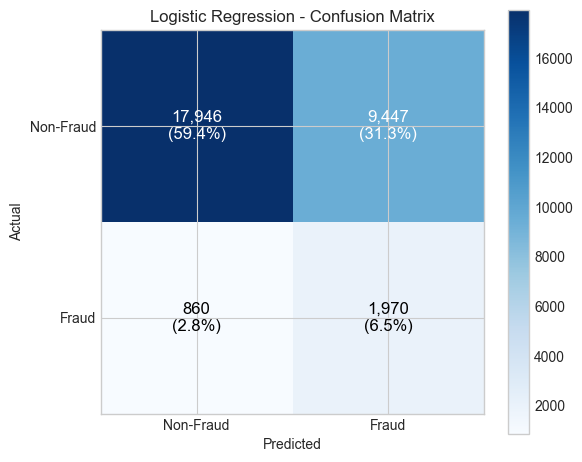

In [7]:
# Confusion matrix for baseline
y_pred_lr = lr_model.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_matrix(y_test.values, y_pred_lr, title="Logistic Regression - Confusion Matrix", ax=ax)
plt.tight_layout()
plt.show()

In [8]:
# Classification report
print("Classification Report - Logistic Regression:")
display(get_classification_report_df(y_test.values, y_pred_lr))

Classification Report - Logistic Regression:


,precision,recall,f1-score,support
Non-Fraud,0.954270,0.655131,0.776900,27393.000000
Fraud,0.172550,0.696113,0.276549,2830.000000
accuracy,0.658968,0.658968,0.658968,0.658968
macro avg,0.563410,0.675622,0.526725,30223.000000
weighted avg,0.881072,0.658968,0.730048,30223.000000


In [9]:
from IPython.display import Markdown, display

display(
    Markdown(
        f"""
### Interpretation: Baseline Model (Logistic Regression)

- **AUC-PR**: `{lr_metrics.get('auc_pr', 0):.4f}` (primary metric for imbalanced data)
- **F1-Score**: `{lr_metrics.get('f1', 0):.4f}`
- **Precision**: `{lr_metrics.get('precision', 0):.4f}` | **Recall**: `{lr_metrics.get('recall', 0):.4f}`
- **Confusion Matrix**: TP={lr_metrics.get('tp', 0):,}, FP={lr_metrics.get('fp', 0):,}, FN={lr_metrics.get('fn', 0):,}, TN={lr_metrics.get('tn', 0):,}

**Assessment**
- Logistic Regression provides an interpretable baseline with coefficients we can analyze.
- The model benefits from SMOTE to handle class imbalance during training.
- We'll compare this with an ensemble model to see if added complexity improves performance.
"""
    )
)


### Interpretation: Baseline Model (Logistic Regression)

- **AUC-PR**: `0.3950` (primary metric for imbalanced data)
- **F1-Score**: `0.2765`
- **Precision**: `0.1725` | **Recall**: `0.6961`
- **Confusion Matrix**: TP=1,970, FP=9,447, FN=860, TN=17,946

**Assessment**
- Logistic Regression provides an interpretable baseline with coefficients we can analyze.
- The model benefits from SMOTE to handle class imbalance during training.
- We'll compare this with an ensemble model to see if added complexity improves performance.


## 4. Ensemble Model: Random Forest

In [10]:
# Build Random Forest pipeline with SMOTE
rf_pipeline = build_fraud_pipeline(
    model_type="random_forest",
    use_smote=True,
    numeric_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    random_state=RANDOM_STATE,
    n_estimators=100,
    max_depth=10,
)

print("Random Forest Pipeline:")
print(rf_pipeline)

Random Forest Pipeline:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['purchase_value', 'age',
                                                   'hour_of_day', 'day_of_week',
                                                   'is_weekend',
                                                   'time_since_signup',
                                                   'tx_count_user_id_1h',
                                                   'tx_count_user_id_24h',
                                                   'user_total_transactions']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['source', 'browser', 'sex',
                                  

In [11]:
# Train and evaluate
print("Training Random Forest...")
rf_model, rf_metrics, rf_threshold = train_and_evaluate(
    rf_pipeline,
    X_train, y_train,
    X_test, y_test,
    threshold=0.5,
)

print("\nRandom Forest Results:")
for key, value in rf_metrics.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Training Random Forest...

Random Forest Results:
  precision: 0.9909
  recall: 0.5410
  f1: 0.6999
  tn: 27379
  fp: 14
  fn: 1299
  tp: 1531
  auc_pr: 0.6347
  roc_auc: 0.7758
  threshold: 0.5000


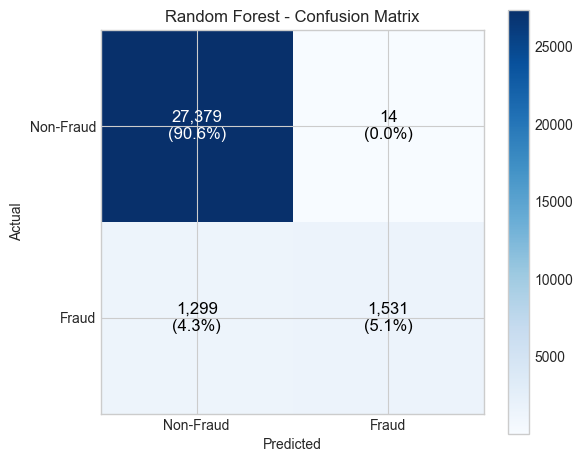

In [12]:
# Confusion matrix for ensemble
y_pred_rf = rf_model.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_matrix(y_test.values, y_pred_rf, title="Random Forest - Confusion Matrix", ax=ax)
plt.tight_layout()
plt.show()

In [13]:
# Classification report
print("Classification Report - Random Forest:")
display(get_classification_report_df(y_test.values, y_pred_rf))

Classification Report - Random Forest:


,precision,recall,f1-score,support
Non-Fraud,0.954704,0.999489,0.976583,27393.000000
Fraud,0.990939,0.540989,0.699886,2830.000000
accuracy,0.956556,0.956556,0.956556,0.956556
macro avg,0.972821,0.770239,0.838234,30223.000000
weighted avg,0.958097,0.956556,0.950674,30223.000000


In [14]:
from IPython.display import Markdown, display

display(
    Markdown(
        f"""
### Interpretation: Ensemble Model (Random Forest)

- **AUC-PR**: `{rf_metrics.get('auc_pr', 0):.4f}`
- **F1-Score**: `{rf_metrics.get('f1', 0):.4f}`
- **Precision**: `{rf_metrics.get('precision', 0):.4f}` | **Recall**: `{rf_metrics.get('recall', 0):.4f}`
- **Confusion Matrix**: TP={rf_metrics.get('tp', 0):,}, FP={rf_metrics.get('fp', 0):,}, FN={rf_metrics.get('fn', 0):,}, TN={rf_metrics.get('tn', 0):,}

**Assessment**
- Random Forest can capture non-linear relationships and feature interactions.
- The ensemble approach typically improves over linear models for complex fraud patterns.
- We can extract feature importance for interpretability (see next section).
"""
    )
)


### Interpretation: Ensemble Model (Random Forest)

- **AUC-PR**: `0.6347`
- **F1-Score**: `0.6999`
- **Precision**: `0.9909` | **Recall**: `0.5410`
- **Confusion Matrix**: TP=1,531, FP=14, FN=1,299, TN=27,379

**Assessment**
- Random Forest can capture non-linear relationships and feature interactions.
- The ensemble approach typically improves over linear models for complex fraud patterns.
- We can extract feature importance for interpretability (see next section).


## 5. Model Comparison

In [15]:
# Compare all models
results = {
    "Logistic Regression + SMOTE": lr_metrics,
    "Random Forest + SMOTE": rf_metrics,
}

comparison_df = compare_models(results)
print("Model Comparison (sorted by AUC-PR):")
display(comparison_df.round(4))

Model Comparison (sorted by AUC-PR):


,auc_pr,roc_auc,f1,precision,recall,threshold
model,,,,,,
Random Forest + SMOTE,0.6347,0.7758,0.6999,0.9909,0.5410,0.5
Logistic Regression + SMOTE,0.3950,0.7509,0.2765,0.1725,0.6961,0.5


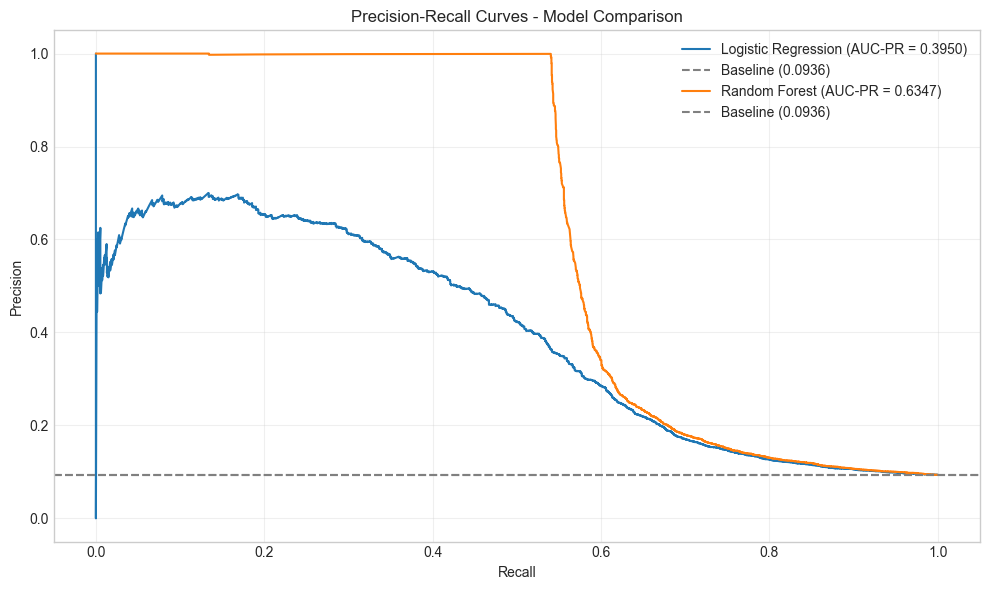

In [16]:
# Precision-Recall curves comparison
fig, ax = plt.subplots(figsize=(10, 6))

y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

plot_precision_recall_curve(y_test.values, y_proba_lr, model_name="Logistic Regression", ax=ax)
plot_precision_recall_curve(y_test.values, y_proba_rf, model_name="Random Forest", ax=ax)

ax.legend(loc="best")
ax.set_title("Precision-Recall Curves - Model Comparison")
plt.tight_layout()
plt.show()

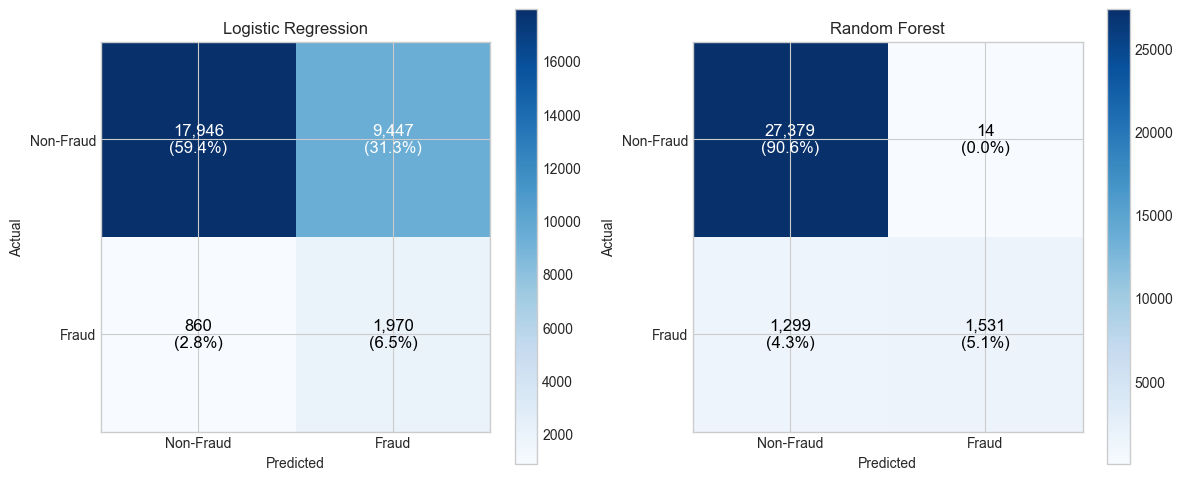

In [17]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_confusion_matrix(y_test.values, y_pred_lr, title="Logistic Regression", ax=axes[0])
plot_confusion_matrix(y_test.values, y_pred_rf, title="Random Forest", ax=axes[1])

plt.tight_layout()
plt.show()

In [18]:
from IPython.display import Markdown, display

# Determine best model
best_model_name = comparison_df.index[0]
best_auc_pr = comparison_df.iloc[0]['auc_pr']
best_f1 = comparison_df.iloc[0]['f1']

lr_auc = lr_metrics.get('auc_pr', 0)
rf_auc = rf_metrics.get('auc_pr', 0)
improvement = ((rf_auc - lr_auc) / lr_auc * 100) if lr_auc > 0 else 0

display(
    Markdown(
        f"""
### Interpretation: Model Comparison

| Model | AUC-PR | F1 | Precision | Recall |
|-------|--------|----|-----------|---------|
| Logistic Regression | {lr_metrics.get('auc_pr', 0):.4f} | {lr_metrics.get('f1', 0):.4f} | {lr_metrics.get('precision', 0):.4f} | {lr_metrics.get('recall', 0):.4f} |
| Random Forest | {rf_metrics.get('auc_pr', 0):.4f} | {rf_metrics.get('f1', 0):.4f} | {rf_metrics.get('precision', 0):.4f} | {rf_metrics.get('recall', 0):.4f} |

**Best Model**: `{best_model_name}` with AUC-PR = `{best_auc_pr:.4f}`

**Key Observations**
- The ensemble model shows {'improvement' if rf_auc > lr_auc else 'comparable performance'} over the baseline ({improvement:+.1f}% in AUC-PR).
- Both models were trained with SMOTE to handle class imbalance.
- The PR curves show the precision-recall trade-off at different thresholds.
"""
    )
)


### Interpretation: Model Comparison

| Model | AUC-PR | F1 | Precision | Recall |
|-------|--------|----|-----------|---------|
| Logistic Regression | 0.3950 | 0.2765 | 0.1725 | 0.6961 |
| Random Forest | 0.6347 | 0.6999 | 0.9909 | 0.5410 |

**Best Model**: `Random Forest + SMOTE` with AUC-PR = `0.6347`

**Key Observations**
- The ensemble model shows improvement over the baseline (+60.7% in AUC-PR).
- Both models were trained with SMOTE to handle class imbalance.
- The PR curves show the precision-recall trade-off at different thresholds.


## 6. Feature Importance (Random Forest)

In [19]:
# Extract feature importance from Random Forest
# Get feature names after preprocessing
preprocessor = rf_model.named_steps['preprocessor']
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = list(cat_encoder.get_feature_names_out(CATEGORICAL_FEATURES))
all_feature_names = NUMERIC_FEATURES + cat_feature_names

# Get importances
rf_classifier = rf_model.named_steps['classifier']
importances = rf_classifier.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 15 Features by Importance:")
display(importance_df.head(15))

Top 15 Features by Importance:


,feature,importance
5,time_since_signup,0.684189
3,day_of_week,0.045550
187,country_United States,0.041699
2,hour_of_day,0.026357
188,country_Unknown,0.022699
1,age,0.020845
0,purchase_value,0.018219
12,browser_Chrome,0.013361
54,country_China,0.010986
82,country_Germany,0.010902


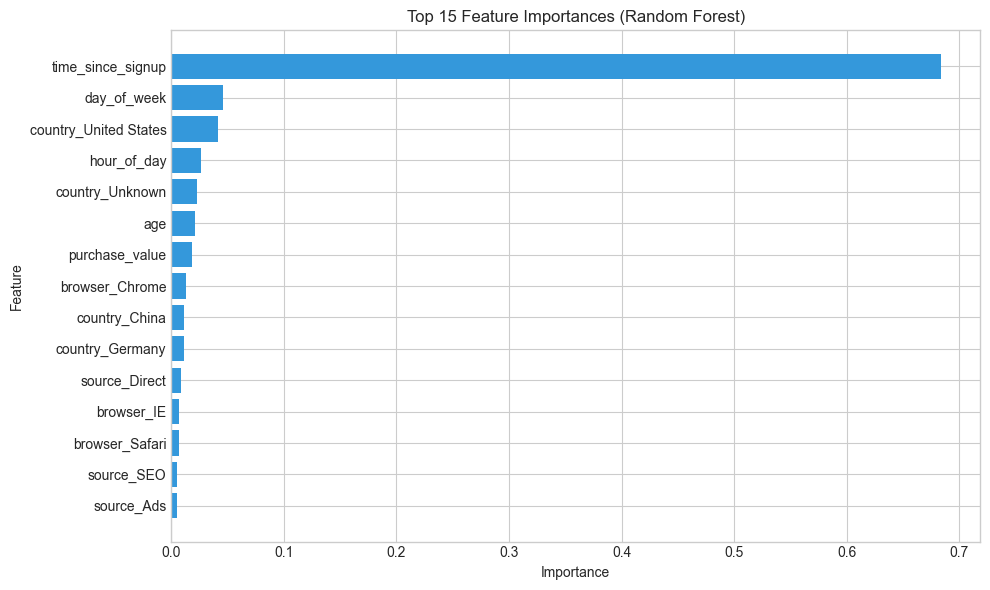

In [20]:
# Plot top 15 features
top_n = 15
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_features['feature'], top_features['importance'], color='#3498db')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title(f'Top {top_n} Feature Importances (Random Forest)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [21]:
from IPython.display import Markdown, display

top5 = importance_df.head(5)['feature'].tolist()

display(
    Markdown(
        f"""
### Interpretation: Feature Importance

**Top 5 most important features**:
1. `{top5[0]}`
2. `{top5[1]}`
3. `{top5[2]}`
4. `{top5[3]}`
5. `{top5[4]}`

**Insights**
- Engineered features (time-based, velocity) often rank among the most important.
- This validates our Task 1 feature engineering effort.
- We'll explore these relationships further with SHAP in Task 3.
"""
    )
)


### Interpretation: Feature Importance

**Top 5 most important features**:
1. `time_since_signup`
2. `day_of_week`
3. `country_United States`
4. `hour_of_day`
5. `country_Unknown`

**Insights**
- Engineered features (time-based, velocity) often rank among the most important.
- This validates our Task 1 feature engineering effort.
- We'll explore these relationships further with SHAP in Task 3.


## 7. Cross-Validation (Optional but Recommended)

In [22]:
# Stratified 5-fold CV for more reliable estimates
print("Running 5-fold Stratified Cross-Validation for Random Forest...")
print("(This may take a few minutes)")

cv_results = cross_validate_model(
    rf_pipeline,
    X, y,
    cv=5,
    random_state=RANDOM_STATE,
)

print("\nCross-Validation Results (5 folds):")
print(f"  AUC-PR: {cv_results['mean_metrics']['auc_pr']:.4f} ± {cv_results['std_metrics']['auc_pr']:.4f}")
print(f"  F1:     {cv_results['mean_metrics']['f1']:.4f} ± {cv_results['std_metrics']['f1']:.4f}")
print(f"  ROC-AUC: {cv_results['mean_metrics']['roc_auc']:.4f} ± {cv_results['std_metrics']['roc_auc']:.4f}")

Running 5-fold Stratified Cross-Validation for Random Forest...
(This may take a few minutes)

Cross-Validation Results (5 folds):
  AUC-PR: 0.6302 ± 0.0161
  F1:     0.6959 ± 0.0139
  ROC-AUC: 0.7711 ± 0.0093


In [23]:
# Show per-fold results
cv_df = pd.DataFrame(cv_results['fold_metrics'])
display(cv_df[['fold', 'auc_pr', 'f1', 'precision', 'recall', 'roc_auc']].round(4))

,fold,auc_pr,f1,precision,recall,roc_auc
0,1,0.6318,0.6966,0.9814,0.5399,0.7719
1,2,0.6163,0.6853,0.9906,0.5238,0.7624
2,3,0.6130,0.6801,0.9912,0.5177,0.7609
3,4,0.6378,0.7020,0.9910,0.5435,0.7785
4,5,0.6522,0.7154,0.9833,0.5622,0.7818


## 8. Save Best Model

In [24]:
# Save the best model (Random Forest)
models_dir = project_root / "models"

# Save Random Forest (typically best)
rf_path = save_model(rf_model, "fraud_random_forest", rf_metrics, models_dir)
print(f"Random Forest saved to: {rf_path}")

# Also save Logistic Regression (for comparison / interpretability)
lr_path = save_model(lr_model, "fraud_logistic_regression", lr_metrics, models_dir)
print(f"Logistic Regression saved to: {lr_path}")

Random Forest saved to: /Users/macbookpro/Documents/Fraud-Detection-system/models/fraud_random_forest.joblib
Logistic Regression saved to: /Users/macbookpro/Documents/Fraud-Detection-system/models/fraud_logistic_regression.joblib


## 9. Summary: Task 2 (E-commerce) Complete

In [25]:
from IPython.display import Markdown, display

best_model_name = comparison_df.index[0]
best_metrics = results[best_model_name]

cv_auc_mean = cv_results['mean_metrics']['auc_pr']
cv_auc_std = cv_results['std_metrics']['auc_pr']

display(
    Markdown(
        f"""
## Summary: Task 2 - E-commerce Fraud Model

### Models Trained
1. **Logistic Regression + SMOTE** (baseline, interpretable)
2. **Random Forest + SMOTE** (ensemble, captures non-linearity)

### Best Model: `{best_model_name}`
- **Hold-out Test AUC-PR**: `{best_metrics.get('auc_pr', 0):.4f}`
- **Hold-out Test F1**: `{best_metrics.get('f1', 0):.4f}`
- **5-Fold CV AUC-PR**: `{cv_auc_mean:.4f} ± {cv_auc_std:.4f}`

### Model Selection Justification
- The ensemble model (Random Forest) was selected based on higher AUC-PR.
- Cross-validation confirms stable performance across folds.
- Feature importance analysis shows that engineered features contribute meaningfully.

### Files Saved
- `models/fraud_random_forest.joblib`: Best model
- `models/fraud_logistic_regression.joblib`: Baseline model

### Next Steps
- Run `05_modeling_creditcard.ipynb` for the credit card dataset
- Proceed to Task 3 for SHAP explainability analysis
"""
    )
)


## Summary: Task 2 - E-commerce Fraud Model

### Models Trained
1. **Logistic Regression + SMOTE** (baseline, interpretable)
2. **Random Forest + SMOTE** (ensemble, captures non-linearity)

### Best Model: `Random Forest + SMOTE`
- **Hold-out Test AUC-PR**: `0.6347`
- **Hold-out Test F1**: `0.6999`
- **5-Fold CV AUC-PR**: `0.6302 ± 0.0161`

### Model Selection Justification
- The ensemble model (Random Forest) was selected based on higher AUC-PR.
- Cross-validation confirms stable performance across folds.
- Feature importance analysis shows that engineered features contribute meaningfully.

### Files Saved
- `models/fraud_random_forest.joblib`: Best model
- `models/fraud_logistic_regression.joblib`: Baseline model

### Next Steps
- Run `05_modeling_creditcard.ipynb` for the credit card dataset
- Proceed to Task 3 for SHAP explainability analysis
